# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [1]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

#from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Beejal\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
#Mount drive
# from google.colab import drive
# drive.mount('/content/drive/')

### 1.Set your project path where you have your data and related files for this lab.

In [3]:
# Current working directory is where my files are. So it's going to be project_path
project_path = os.getcwd()
project_path

'D:\\Beejal\\Education\\Great Lakes\\Residency-09\\Course-Lab\\External'

### 2. Set the necessary parameters

## Setup

In [4]:
path_train = f'{project_path}{os.sep}Data{os.sep}train{os.sep}'   #Path for your train data
path_train

'D:\\Beejal\\Education\\Great Lakes\\Residency-09\\Course-Lab\\External\\Data\\train\\'

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [5]:
if (os.path.exists(path_train) == False):
    print(f'{path_train} does not exist. Creating now...')
    os.mkdir(path_train)
    from zipfile import ZipFile
    with ZipFile(f'{project_path}{os.sep}Data{os.sep}train.zip', 'r') as zf:
        zf.extractall(path_train)
    print('Created. Extracted image files')
else:
    print("Path exists")

Path exists


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [6]:
#For simplicity we have added the required code here.
# [Beejal] Done above

In [7]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [8]:
imagelist = []
masklist  = []

dirs = os.listdir(f'{path_train}')
for dirctry in dirs:
    dir_path = f'{path_train}{dirctry}'
    if dirctry == 'images':
        imagelist = os.listdir(dir_path) 
    else:
        masklist = os.listdir(dir_path)

print(len(imagelist), len(masklist))

4000 4000


In [9]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

fff987cdb3.png
fff987cdb3.png
0108518d1e.png
0108518d1e.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


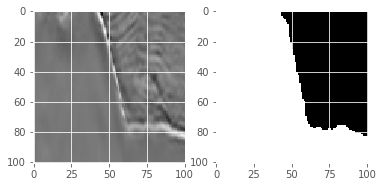

In [10]:
import matplotlib.pyplot as plt
import cv2

path_train_img = f'{path_train}images{os.sep}'
path_train_msk = f'{path_train}masks{os.sep}'

img_idx = 10 

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(f'{path_train_img}{imagelist[img_idx]}'))
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(f'{path_train_msk}{masklist[img_idx]}'))

plt.show()

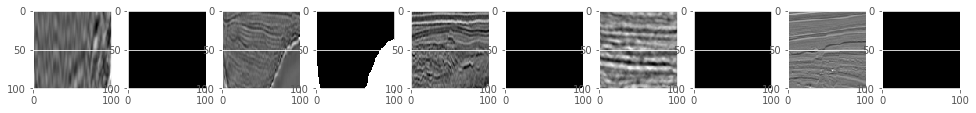

In [11]:
# Let's plot a few more images & their respective masks
ids= ['1f1cc6b3a4.png','5b7c160d0d.png','6c40978ddf.png','7dfdf6eeb8.png','7e5a6e5013.png']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = cv2.imread(f'{path_train_img}{img_name}')
    img_mask = cv2.imread(f'{path_train_msk}{img_name}')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [12]:
# Let's inspect one of the images
cv2.imread(f'{path_train_img}{ids[0]}').shape, cv2.imread(f'{path_train_msk}{ids[0]}').shape

((101, 101, 3), (101, 101, 3))

In [13]:
# The images are gray with 3 channels. Let's check if each channel has same or different data
img = cv2.imread(f'{path_train_img}{ids[0]}')
# First we compute difference between two of the channels. And than take sum of the flattened output.
# If this sum is zero then, both the frames are same
print('Difference Sum of Frame-1 * Frame-2 = ', sum(img[:,:,0].ravel() - img[:,:,1].ravel()))
# The sum is zero, hence both the frames are same. Let's do it for Frame-1 & Frame-3 as well.
print('Difference Sum of Frame-1 * Frame-3 = ', sum(img[:,:,0].ravel() - img[:,:,2].ravel()))
# Finally let's check between Frame-2 & Frame-3
print('Difference Sum of Frame-2 * Frame-3 = ', sum(img[:,:,1].ravel() - img[:,:,2].ravel()))

# So instead of processing all three frames, we can just take one of the frames. This should reduce the computation.

Difference Sum of Frame-1 * Frame-2 =  0
Difference Sum of Frame-1 * Frame-3 =  0
Difference Sum of Frame-2 * Frame-3 =  0


# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [14]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
INPUT_SIZE = (IMG_HEIGHT, IMG_WIDTH, 1)

In [15]:
from skimage.transform import resize as imresize
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), IMG_HEIGHT, IMG_WIDTH, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), IMG_HEIGHT, IMG_WIDTH, 1)), dtype=np.float32) #Create an array for mask
    
    for img_name in imagelist: 
        k = imagelist.index(img_name)
        ##Add image_path
        image_path =  f'{path_train_img}{img_name}'
        
        ##Add mask_path
        mask_path = f'{path_train_msk}{img_name}'
        
        
        # Load images and resize to (128,128,1)
        resized_img = imresize(cv2.imread(image_path), INPUT_SIZE, mode='constant', preserve_range=True)
        
        # Load masks and resize to (128,128,1)
        #/*** Add your code here***/
        resized_mask = imresize(cv2.imread(mask_path), INPUT_SIZE, mode='constant', preserve_range=True)
        
        # Save images
        X[k] = resized_img / 255
        y[k] = resized_mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

train = True
X, y = get_data()

C:\Users\Beejal\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Done!


In [16]:
X.shape, y.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

In [17]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

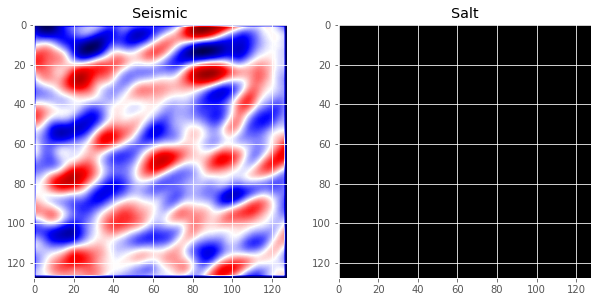

In [18]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [19]:
X_train[ix].shape

(128, 128, 1)

### 8. Define loss and dice_coeff function.

In [20]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [21]:
from tensorflow.keras.losses import binary_crossentropy
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [22]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [23]:
BACKBONE = 'seresnet34'

preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
x_train = preprocess_input(X_train)
x_valid = preprocess_input(X_valid)

# define model
base_model = sm.Unet(backbone_name=BACKBONE, encoder_weights='imagenet', input_shape=(None, None, 3), encoder_freeze=True)
# Parameters:
# backbone_name – name of classification model (without last dense layers) used as feature extractor 
#     to build segmentation model.
# encoder_weights – one of None (random initialization), imagenet (pre-training on ImageNet).
# input_shape – shape of input data/image (H, W, C), in general case you do not need to set H and W shapes, 
#     just pass (None, None, C) to make your model be able to process images af any size, but H and W of input images 
#     should be divisible by factor 32. Default is (None, None, 3)
# IMPORTANT NOTE: If we set input channels not equal to 3 (Since in our case it is 1), we have to set encoder_weights=None.
# Which means we cannot use the weights learned on Imagenet. So we train our weights using our training data.
# Alternatively, we can add a layer on top of our base_model as shown below too.

inp = Input(shape=INPUT_SIZE)
l1 = Conv2D(3, (1, 1))(inp) # map 1 channel data to 3 channels
out = base_model(l1)

#x = Reshape((IMG_HEIGHT, IMG_WIDTH))(out)
model = Model(inp, out, name=base_model.name)

model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 3)       6         
_________________________________________________________________
model_2 (Model)              multiple                  24617350  
Total params: 24,617,356
Trainable params: 3,167,066
Non-trainable params: 21,450,290
_________________________________________________________________


In [24]:
model.compile(
    'Nadam',
    loss=loss,
    metrics=[dice_coefficient],
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [25]:
x_train.shape, y_train.shape

((3400, 128, 128, 1), (3400, 128, 128, 1))

In [26]:
lr_reduce = ReduceLROnPlateau(monitor='dice_coefficient', factor=0.1, epsilon=1e-5, patience=5, verbose=1)
es = EarlyStopping(monitor='dice_coefficient', patience=30, verbose=1, mode='auto')

C:\Users\Beejal\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,    
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[lr_reduce, es]
)


Train on 3400 samples, validate on 600 samples
Epoch 1/100
3400/3400 [==============================] - 44s 13ms/step - loss: 0.8273 - dice_coefficient: 0.6371 - val_loss: 11.1034 - val_dice_coefficient: 0.3537
Epoch 2/100
3400/3400 [==============================] - 34s 10ms/step - loss: 0.4709 - dice_coefficient: 0.7841 - val_loss: 8.5514 - val_dice_coefficient: 0.3567
Epoch 3/100
3400/3400 [==============================] - 34s 10ms/step - loss: 0.3872 - dice_coefficient: 0.8236 - val_loss: 2.7541 - val_dice_coefficient: 0.2756
Epoch 4/100
3400/3400 [==============================] - 34s 10ms/step - loss: 0.3294 - dice_coefficient: 0.8519 - val_loss: 3.1282 - val_dice_coefficient: 0.2753
Epoch 5/100
3400/3400 [==============================] - 34s 10ms/step - loss: 0.2723 - dice_coefficient: 0.8750 - val_loss: 3.2790 - val_dice_coefficient: 0.1584
Epoch 6/100
3400/3400 [==============================] - 35s 10ms/step - loss: 0.2432 - dice_coefficient: 0.8895 - val_loss: 3.7987 - va

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [28]:
#preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_valid, verbose=1)

600/600 [==============================] - 23s 38ms/step


In [29]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [51]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    print(ix)
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow((y[ix].squeeze()))
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='seismic')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors=['green'], levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors=['green'], levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

19


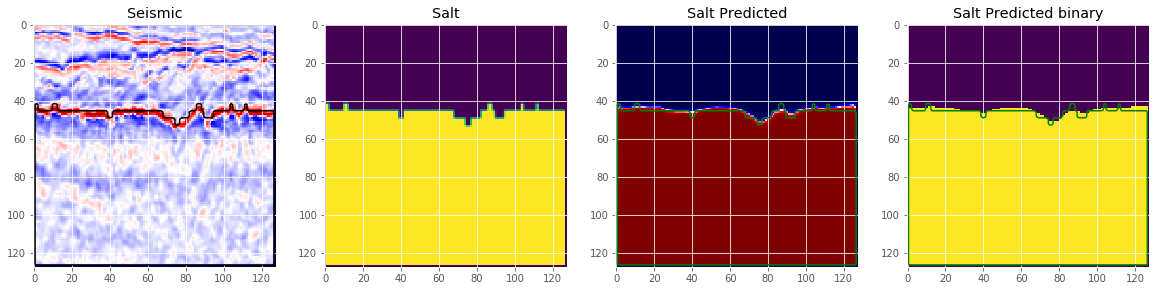

In [56]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [32]:
pd.DataFrame(y_valid[69][:,:,0]).to_excel("Actual.xls")
pd.DataFrame(preds_val[69][:,:,0]).to_excel("Predicted.xls")

In [33]:
y_valid[69].shape, y_valid[69].squeeze().shape

((128, 128, 1), (128, 128))

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

## Extra

### How squeeze function works?

In [34]:
c = np.array([[1, 2, 3], [4, 5, 6]])
print(c)
d = (c!=2)*1.0 
print(d.shape)
# e = cv2.resize(d, (128, 128))
# print(e)
# f = 1.0*(e > 0.2)
# print(f)
d.squeeze().shape

[[1 2 3]
 [4 5 6]]
(2, 3)


(2, 3)

### How contour works?

(9,)
(9, 1)
(9, 9)
[[ 1  2  3  4  5  6  7  8  9]
 [ 2  4  6  8 10 12 14 16 18]
 [ 3  6  9 12 15 18 21 24 27]
 [ 4  8 12 16 20 24 28 32 36]
 [ 5 10 15 20 25 30 35 40 45]
 [ 6 12 18 24 30 36 42 48 54]
 [ 7 14 21 28 35 42 49 56 63]
 [ 8 16 24 32 40 48 56 64 72]
 [ 9 18 27 36 45 54 63 72 81]]


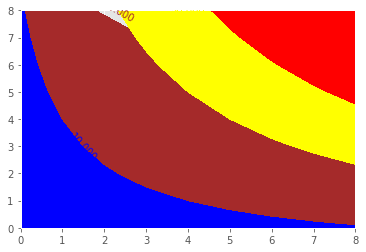

In [35]:
x = np.arange(1, 10)
#print(x)
print(x.shape)
y = x.reshape(-1, 1)
#print(y)
print(y.shape)
h = x * y
print(h.shape)
print(h)
cs = plt.contourf(h, levels=[10, 30, 50],
    colors=['brown', 'yellow', 'green'], extend='both')
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
plt.clabel(cs, inline=1, fontsize=10)
cs.changed()

In [36]:
delta = 0.025
i = np.arange(-3.0, 3.0, delta)
j = np.arange(-2.0, 2.0, delta)
I, J = np.meshgrid(i, j)
Z1 = np.exp(-I**2 - J**2)
Z2 = np.exp(-(I - 1)**2 - (J - 1)**2)
Z = (Z1 - Z2) * 2

In [37]:
i.shape, I.shape

((240,), (160, 240))

In [38]:
j.shape, J.shape

((160,), (160, 240))

In [39]:
Z1.shape

(160, 240)

In [40]:
Z2.shape

(160, 240)

In [41]:
Z.shape

(160, 240)

In [42]:
Z[0].shape

(240,)

Text(0.5, 1.0, 'Simplest default with labels')

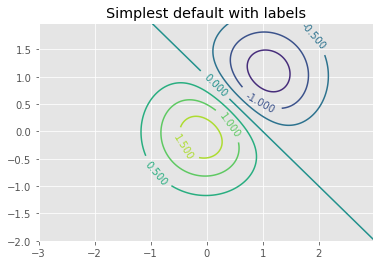

In [43]:
fig, ax = plt.subplots()
CS = ax.contour(I, J, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

Text(0.5, 1.0, 'Simplest default with labels')

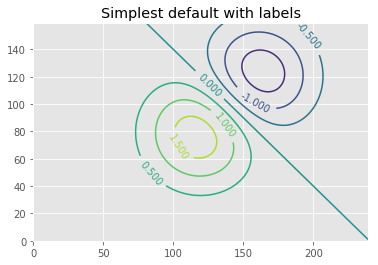

In [44]:
fig, ax = plt.subplots()
CS = ax.contour(Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [45]:
pd.DataFrame(Z[100:101, 100])

,0
0,1.048891
